# Tugas Besar PCD Kelompok 7
**Seagata Ade Barus (1301210371)**

## Setup

In [1]:
#import
import os
import cv2
import json
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage.feature import local_binary_pattern

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce GTX 1050
Using device: cuda


## Feature Extraction & Preprocessing

### Gabor Filter

In [5]:
# gabor filter
def applyGaborFilter(image, kernel_size=21, sigma=5.0, theta=0, lambd=10.0, gamma=0.5):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lambd, gamma, ktype=cv2.CV_32F)
    filteredGray = cv2.filter2D(grayImage, cv2.CV_8UC3, kernel)
    filteredImage = cv2.merge([filteredGray, filteredGray, filteredGray])
    return filteredImage

In [11]:
# process image into gabor filter
def GaborFilter(folder_path, label):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(folder_path, filename)
            image = cv2.imread(filepath)
            if image is None:
                print(f"Failed to load image: {filepath}")
            else:
                image = cv2.resize(image, (560, 560))
                filteredImage = applyGaborFilter(image)
                data.append(img_to_array(filteredImage))
                labels.append(label)
    return np.array(data), np.array(labels)

In [12]:
# process data
realImg, realLabels = GaborFilter('Real', label=0)
aiImg, aiLabels = GaborFilter('AI', label=1)

In [13]:
# Combine & split data
img = np.concatenate((realImg, aiImg), axis=0)
labels = np.concatenate((realLabels, aiLabels), axis=0)
img = img / 255.0
labels = to_categorical(labels, num_classes=2)

X_train, X_val, y_train, y_val = train_test_split(img, labels, test_size=0.2, random_state=34)

### LBP

In [3]:
# Local Binary Pattern(s?)
def localBinaryPattern(folder, label):
    images = []
    labels = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img,(560, 560))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
            lbp_rgb = cv2.merge([lbp, lbp, lbp])
            images.append(lbp_rgb)
            labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# Process Image & Labels
realImg2, realLabels2 = localBinaryPattern("Real", 0)
aiImg2, aiLabels2 = localBinaryPattern("AI", 1)

images = np.concatenate((realImg2, aiImg2), axis=0)
labels = np.concatenate((realLabels2, aiLabels2), axis=0)

labels = to_categorical(labels, 2)

In [5]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(images, labels, test_size=0.2, random_state=34)

### Default CNN Feature Maps

In [3]:
# default preprocess untuk MobileNetV3Large
def preprocess(folder, label):
    images = []
    labels = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img,(560,560))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# process images & labels
realImg3, realLabels3 = preprocess("Real", 0)
aiImg3, aiLabels3 = preprocess("AI", 1)

images = np.concatenate((realImg3, aiImg3), axis=0)
labels = np.concatenate((realLabels3, aiLabels3), axis=0)

images = preprocess_input(images)
labels = to_categorical(labels, 2)

In [5]:
x_train3, x_val3, y_train3, y_val3 = train_test_split(images, labels, test_size=0.2, random_state=42)

## Model

In [7]:
# inisisasi model pre-trained MobileNetV3Large
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(560, 560, 3))

c:\Users\wagam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


### Gabor Filter

In [3]:
# modifikasi model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

NameError: name 'Sequential' is not defined

In [9]:
#compile
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

In [10]:
#fit
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=10,
    verbose=2
)

Epoch 1/10
10/10 - 336s - 34s/step - accuracy: 0.5234 - loss: 0.7072 - val_accuracy: 0.5500 - val_loss: 0.6907
Epoch 2/10
10/10 - 267s - 27s/step - accuracy: 0.5594 - loss: 0.6863 - val_accuracy: 0.5250 - val_loss: 0.7132
Epoch 3/10
10/10 - 261s - 26s/step - accuracy: 0.6156 - loss: 0.6608 - val_accuracy: 0.5250 - val_loss: 0.7115
Epoch 4/10
10/10 - 269s - 27s/step - accuracy: 0.6516 - loss: 0.6387 - val_accuracy: 0.5250 - val_loss: 0.7208
Epoch 5/10
10/10 - 266s - 27s/step - accuracy: 0.6781 - loss: 0.6165 - val_accuracy: 0.5250 - val_loss: 0.7341
Epoch 6/10
10/10 - 267s - 27s/step - accuracy: 0.7047 - loss: 0.5976 - val_accuracy: 0.5250 - val_loss: 0.7526
Epoch 7/10
10/10 - 263s - 26s/step - accuracy: 0.7031 - loss: 0.5792 - val_accuracy: 0.5250 - val_loss: 0.7703
Epoch 8/10
10/10 - 251s - 25s/step - accuracy: 0.7500 - loss: 0.5638 - val_accuracy: 0.5250 - val_loss: 0.8144
Epoch 9/10
10/10 - 253s - 25s/step - accuracy: 0.7406 - loss: 0.5496 - val_accuracy: 0.5250 - val_loss: 0.8129
E

### LBP

In [10]:
model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

In [11]:
model2.compile(optimizer=Adam(learning_rate=0.01),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

In [12]:
history2 = model2.fit(x_train2, 
                      y_train2, 
                      validation_data=(x_val2, y_val2),
                      epochs=10,
                      verbose=2)

Epoch 1/10
25/25 - 428s - 17s/step - accuracy: 0.6888 - loss: 0.9255 - val_accuracy: 0.5050 - val_loss: 45856284672.0000
Epoch 2/10
25/25 - 335s - 13s/step - accuracy: 0.7738 - loss: 0.4750 - val_accuracy: 0.5050 - val_loss: 17498873856.0000
Epoch 3/10
25/25 - 348s - 14s/step - accuracy: 0.8225 - loss: 0.4071 - val_accuracy: 0.5050 - val_loss: 2514144512.0000
Epoch 4/10
25/25 - 337s - 13s/step - accuracy: 0.8037 - loss: 0.4490 - val_accuracy: 0.5050 - val_loss: 6096154112.0000
Epoch 5/10
25/25 - 334s - 13s/step - accuracy: 0.8600 - loss: 0.3149 - val_accuracy: 0.5050 - val_loss: 61805948928.0000
Epoch 6/10
25/25 - 353s - 14s/step - accuracy: 0.8188 - loss: 0.3840 - val_accuracy: 0.5050 - val_loss: 77983825920.0000
Epoch 7/10
25/25 - 367s - 15s/step - accuracy: 0.8375 - loss: 0.4733 - val_accuracy: 0.4950 - val_loss: 10908165120.0000
Epoch 8/10
25/25 - 341s - 14s/step - accuracy: 0.8037 - loss: 0.4028 - val_accuracy: 0.5050 - val_loss: 3025725952.0000
Epoch 9/10
25/25 - 355s - 14s/step 

### Default

In [7]:
model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

In [8]:
model3.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

In [9]:
history3 = model3.fit(x_train3, 
                      y_train3, 
                      validation_data=(x_val3, y_val3), 
                      epochs=40, 
                      batch_size=64,
                      verbose=2)

Epoch 1/40


13/13 - 238s - loss: 0.7417 - accuracy: 0.5702 - val_loss: 0.7356 - val_accuracy: 0.6000 - 238s/epoch - 18s/step
Epoch 2/40
13/13 - 207s - loss: 0.6112 - accuracy: 0.6855 - val_loss: 0.7227 - val_accuracy: 0.6250 - 207s/epoch - 16s/step
Epoch 3/40
13/13 - 207s - loss: 0.5294 - accuracy: 0.7594 - val_loss: 0.6600 - val_accuracy: 0.6650 - 207s/epoch - 16s/step
Epoch 4/40
13/13 - 205s - loss: 0.4797 - accuracy: 0.7870 - val_loss: 0.6260 - val_accuracy: 0.7050 - 205s/epoch - 16s/step
Epoch 5/40
13/13 - 206s - loss: 0.4472 - accuracy: 0.8208 - val_loss: 0.6164 - val_accuracy: 0.6700 - 206s/epoch - 16s/step
Epoch 6/40
13/13 - 207s - loss: 0.4157 - accuracy: 0.8396 - val_loss: 0.5924 - val_accuracy: 0.6900 - 207s/epoch - 16s/step
Epoch 7/40
13/13 - 204s - loss: 0.3877 - accuracy: 0.8647 - val_loss: 0.6173 - val_accuracy: 0.6900 - 204s/epoch - 16s/step
Epoch 8/40
13/13 - 200s - loss: 0.3598 - accuracy: 0.8772 - val_loss: 0.5884 - val_accuracy: 0.6950 - 200s/epoch - 15s/step
Epoch 

## Save & Load

### Gabor Filter

In [12]:
#save
model.save('modelGaborFilter.keras')
with open('history.json', 'w') as f:
    json.dump(history.history, f)

In [18]:
#load
model = load_model('modelGaborFilter.keras')
with open('history.json', 'r') as f:
    history = json.load(f)

### LBP

In [13]:
#save
model2.save('modelLBP.keras')
with open('history2.json', 'w') as f:
    json.dump(history2.history, f)

In [14]:
#load
model2 = load_model('modelLBP.keras')
with open('history3.json', 'r') as f:
    history2 = json.load(f)

### Default

In [10]:
#save
model3.save('modelDefault.keras')
with open('history3.json', 'w') as f:
    json.dump(history3.history, f)

In [ ]:
#load
model3 = load_model('model.keras')
with open('history3.json', 'r') as f:
    history3 = json.load(f)

## Evaluation

### Gabor Filter

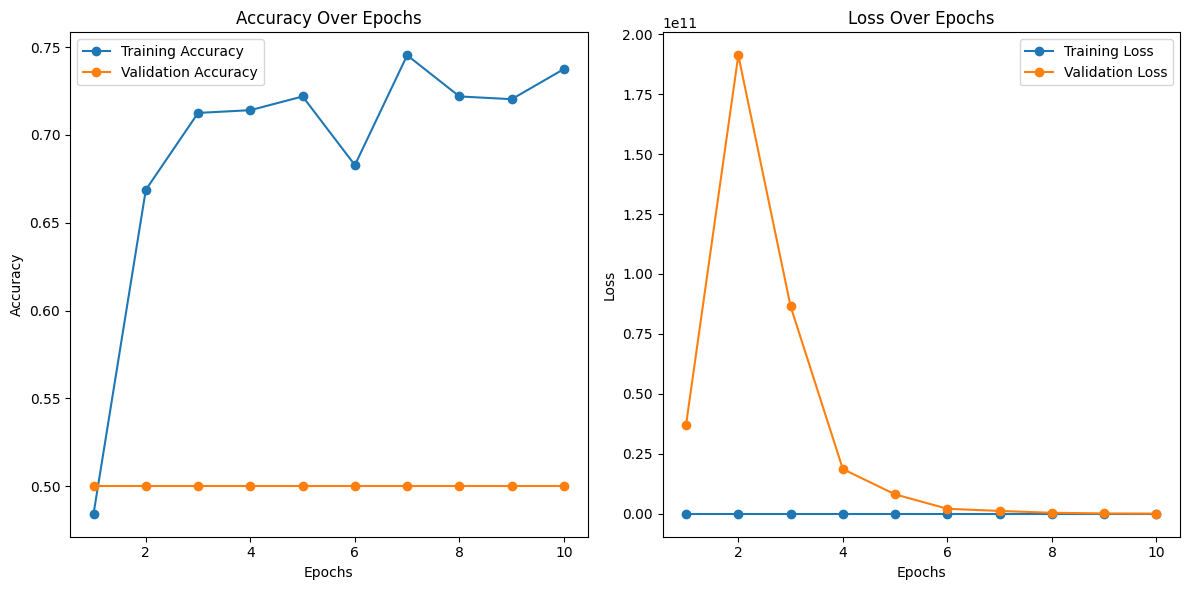

In [ ]:
#history
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)    
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step


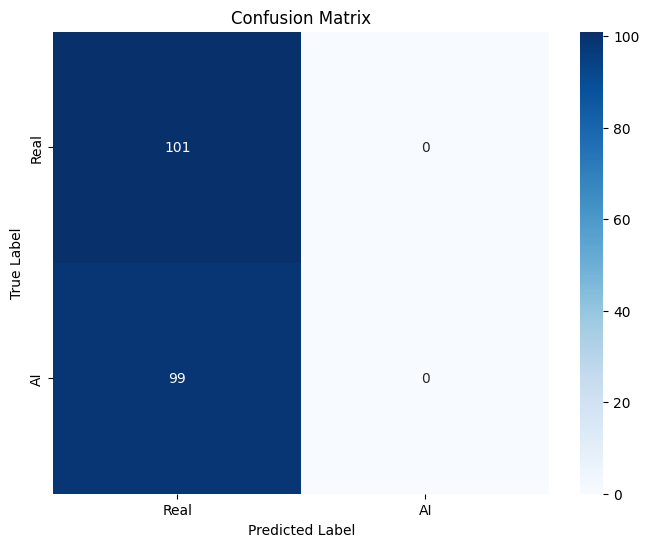

In [22]:
#confusion matrix
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'AI'], yticklabels=['Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Classification report
report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=['Real', 'AI'])
print(report)

              precision    recall  f1-score   support

        Real       0.51      1.00      0.67       101
          AI       0.00      0.00      0.00        99

    accuracy                           0.51       200
   macro avg       0.25      0.50      0.34       200
weighted avg       0.26      0.51      0.34       200



c:\Users\wagam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wagam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wagam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### LBP

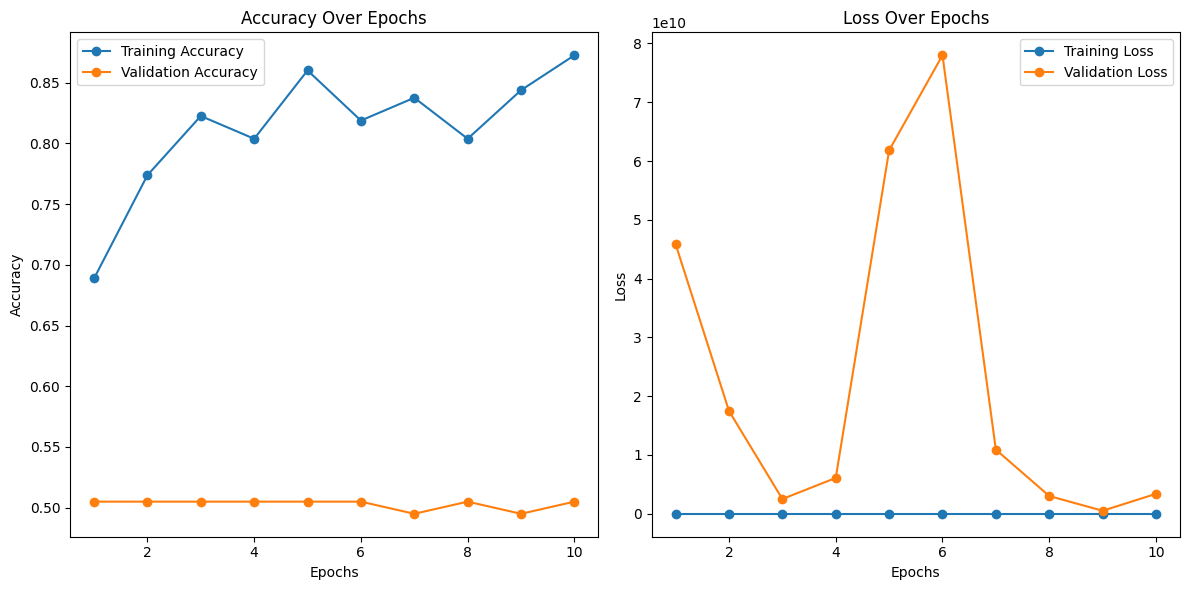

In [17]:
#history
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step


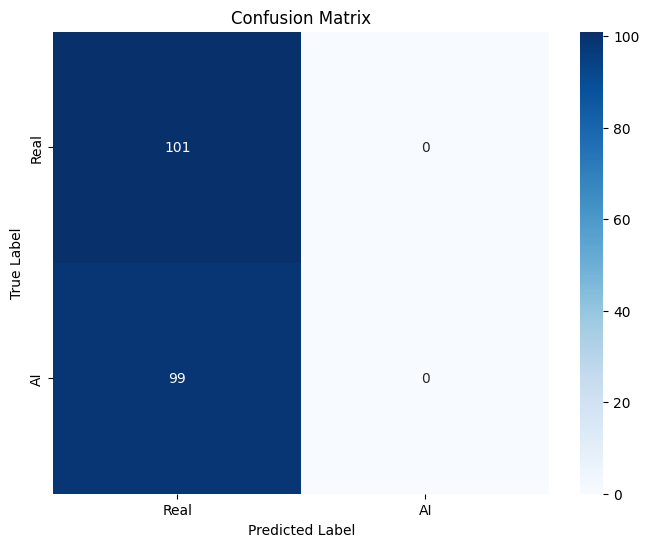

In [15]:
# confusion matrix
y_val_pred = model2.predict(x_val2)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val2, axis=1)

cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'AI'], yticklabels=['Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Classification report
report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=['Real', 'AI'])
print(report)

              precision    recall  f1-score   support

        Real       0.51      1.00      0.67       101
          AI       0.00      0.00      0.00        99

    accuracy                           0.51       200
   macro avg       0.25      0.50      0.34       200
weighted avg       0.26      0.51      0.34       200



c:\Users\wagam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wagam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wagam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Default CNN Feature Maps

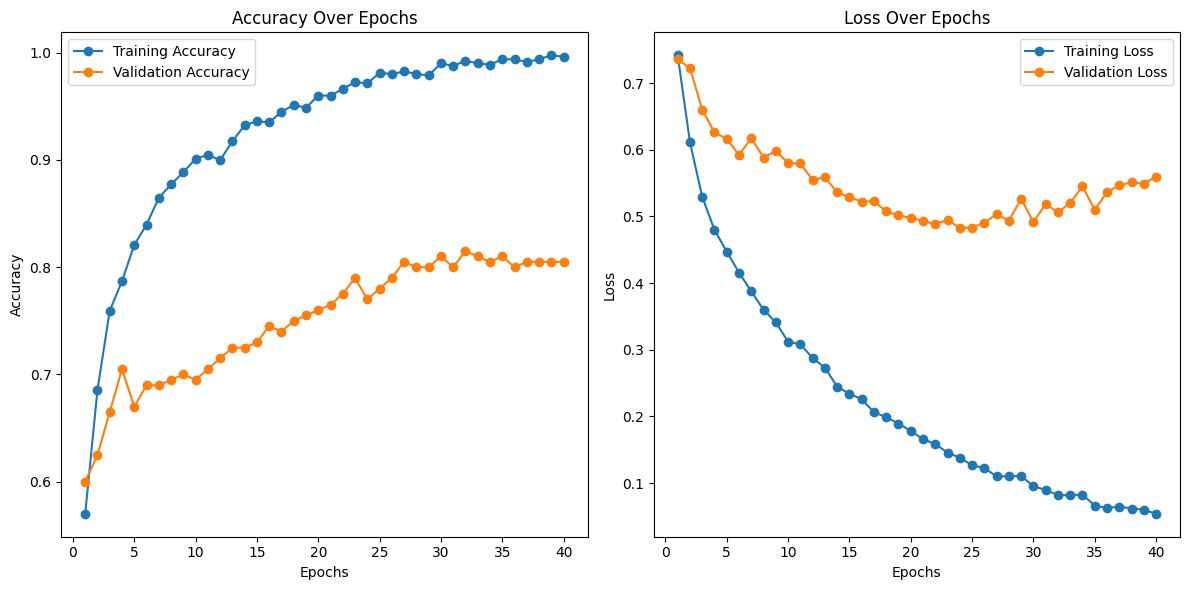

In [11]:
#history
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

7/7 [==============================] - 17s 2s/step


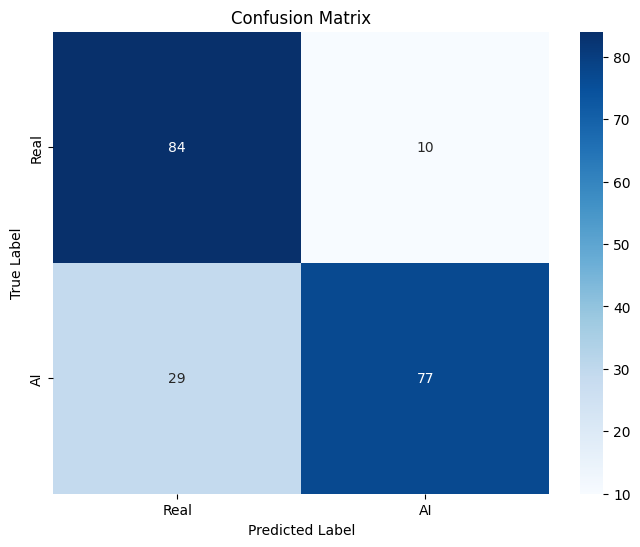

In [ ]:
# Confusion matrix
y_val_pred = model3.predict(x_val3)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val3, axis=1)

cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'AI'], yticklabels=['Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Classification report
report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=['Real', 'AI'])
print(report)

Classification Report:
               precision    recall  f1-score   support

        Real       0.74      0.89      0.81        94
          AI       0.89      0.73      0.80       106

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.80       200
weighted avg       0.82      0.81      0.80       200

